In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# EDA

<BarContainer object of 8 artists>

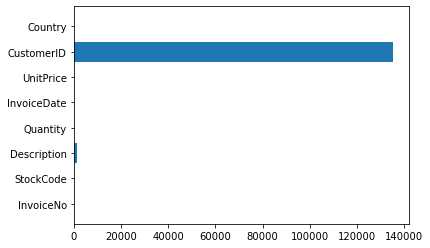

In [4]:
null_values = pd.DataFrame(df.isnull().sum(),columns=['count_value'])
plt.barh(null_values.index,null_values["count_value"])

## Missing values

In [5]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
InvoiceNo,InvoiceNo,0.000000
StockCode,StockCode,0.000000
Description,Description,0.268311
Quantity,Quantity,0.000000
InvoiceDate,InvoiceDate,0.000000
UnitPrice,UnitPrice,0.000000
CustomerID,CustomerID,24.926694
Country,Country,0.000000


<AxesSubplot:xlabel='UnitPrice'>

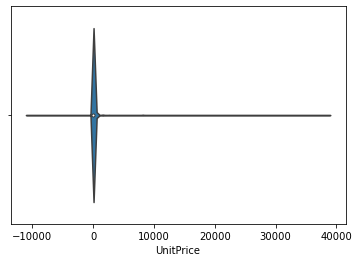

In [6]:
sns.violinplot(df.UnitPrice)


<AxesSubplot:xlabel='Quantity'>

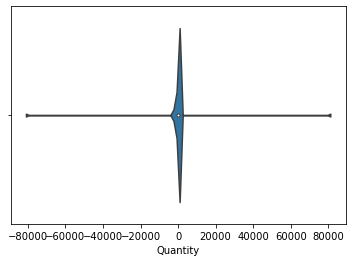

In [7]:
sns.violinplot(df.Quantity)


In [8]:
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [9]:
df['InvoiceDate'].max()


'9/9/2011 9:52'

## RFM 

In [17]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate,format="%m/%d/%Y %H:%M")
df["date"] = df.InvoiceDate.dt.date
recency_df = df.groupby(["CustomerID"],as_index=False)["date"].max()
recency_df.columns = ['CustomerID','Last_Purchase']
recency_df['Recency'] = recency_df.Last_Purchase.apply(lambda x : (datetime.date(2011,12,9) - x).days)
recency_df.drop(columns=['Last_Purchase'],inplace=True)

recency_df

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4333,18280.0,277
4334,18281.0,180
4335,18282.0,7
4336,18283.0,3


In [18]:
frequency_df = df.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [19]:
df['Total_cost'] = df['UnitPrice'] * df['Quantity']
monetary_df=df.groupby('CustomerID',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['CustomerID','Monetary']

In [20]:
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [74]:
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm.set_index('CustomerID',inplace=True)

In [22]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,2,178.05


## Segmentation

In [26]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
n_clusters = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in n_clusters]
score = [kmeans[i].fit(rfm).score(rfm) for i in range(len(kmeans))]


Text(0.5, 1.0, 'Elbow plot for optimal number of clusters')

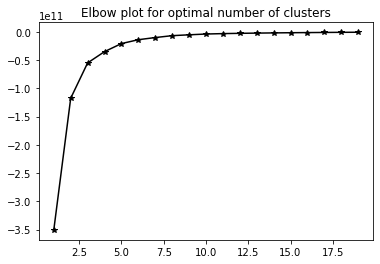

In [30]:
plt.plot(n_clusters,score,marker="*",c="black")
plt.title("Elbow plot for optimal number of clusters")

In [32]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm)


In [33]:
kmeans

KMeans(n_clusters=3, random_state=0)

In [35]:
rfm['cluster'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,310,1,334.40,0


<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

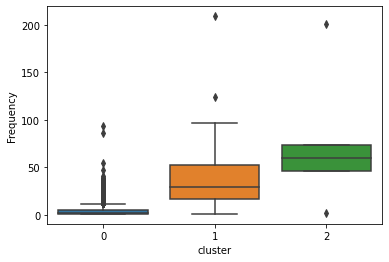

In [38]:
sns.boxplot(rfm.cluster,rfm.Frequency)


<AxesSubplot:xlabel='cluster', ylabel='Recency'>

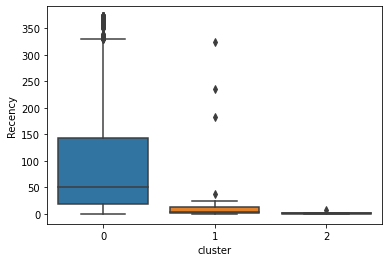

In [40]:
sns.boxplot(rfm.cluster,rfm.Recency)


<AxesSubplot:xlabel='cluster', ylabel='Monetary'>

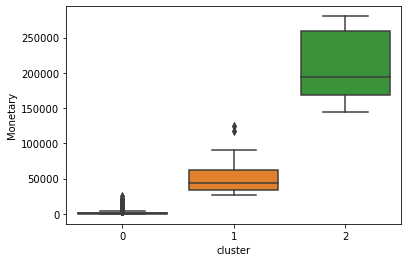

In [41]:
sns.boxplot(rfm.cluster,rfm.Monetary)


In [42]:
quantile = rfm.quantile(q=[0.25,0.5,0.75])


In [43]:
quantile

,Recency,Frequency,Monetary,cluster
0.25,17.00,1.0,307.415,0.0
0.50,50.00,2.0,674.485,0.0
0.75,141.75,5.0,1661.740,0.0


In [51]:
#lower the recency, the better
def Recency_Score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def Frequency_Monetary_Score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [52]:
rfm['R_Quartile'] = rfm['Recency'].apply(Recency_Score,args=('Recency',quantile))
rfm['F_Quartile'] = rfm['Frequency'].apply(Recency_Score,args=('Frequency',quantile))
rfm['M_Quartile'] = rfm['Monetary'].apply(Recency_Score,args=('Monetary',quantile))


In [54]:
rfm['RFMScore'] = rfm.R_Quartile.map(str) \
                            + rfm.F_Quartile.map(str) \
                            + rfm.M_Quartile.map(str)

In [56]:
rfm.groupby('cluster').mean()


,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
cluster,,,,,,
0,92.624971,3.901651,1443.895793,2.504069,2.30737,2.487096
1,30.125000,42.781250,51703.138437,1.406250,3.84375,4.000000
2,2.000000,76.400000,209342.334000,1.000000,3.60000,4.000000


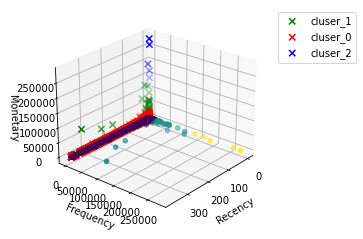

In [73]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=rfm['Recency']
yline=rfm['Frequency']
zline=rfm['Monetary']

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

color_dict = {'0':'red', '1':'green', '2':'blue'}
names = rfm['cluster'].unique()
for s in names:
    embedding = rfm.loc[rfm['cluster'] == s]
    sc = ax.scatter(embedding.iloc[:,0], embedding.iloc[:,1], embedding.iloc[:,2], s=40,
    c=[color_dict[str(i)] for i in embedding['cluster']], marker='x',  label="cluser_"+ str(s))
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ax.scatter3D(xline, zline,yline,c=rfm["cluster"])
ax.view_init(25, 40)
